# 3. Algorithm Comparison - Customer Segmentation

**Goal:** Compare K-Means, DBSCAN, and Gaussian Mixture Models (GMM) on the RFM-transformed customer data.

**Evaluation Metrics:**
- Silhouette Score (cluster separation)
- Davies-Bouldin Index (cluster compactness)
- Calinski-Harabasz Score (variance ratio)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Load preprocessed RFM data
rfm = pd.read_csv('../data/processed/rfm_data.csv', index_col='CustomerID')

# Log transform and scale
rfm_log = np.log1p(rfm)
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)

print(f"Data shape: {rfm_scaled.shape}")

Data shape: (4339, 3)


## 1. K-Means Clustering

Fast, scalable, assumes spherical clusters.

In [2]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(rfm_scaled)

kmeans_metrics = {
    'Silhouette': silhouette_score(rfm_scaled, kmeans_labels),
    'Davies-Bouldin': davies_bouldin_score(rfm_scaled, kmeans_labels),
    'Calinski-Harabasz': calinski_harabasz_score(rfm_scaled, kmeans_labels)
}

print("K-Means Metrics:")
for metric, value in kmeans_metrics.items():
    print(f"  {metric}: {value:.3f}")

K-Means Metrics:
  Silhouette: 0.336
  Davies-Bouldin: 1.012
  Calinski-Harabasz: 3313.963


## 2. DBSCAN (Density-Based)

Can find arbitrary-shaped clusters and identify outliers.

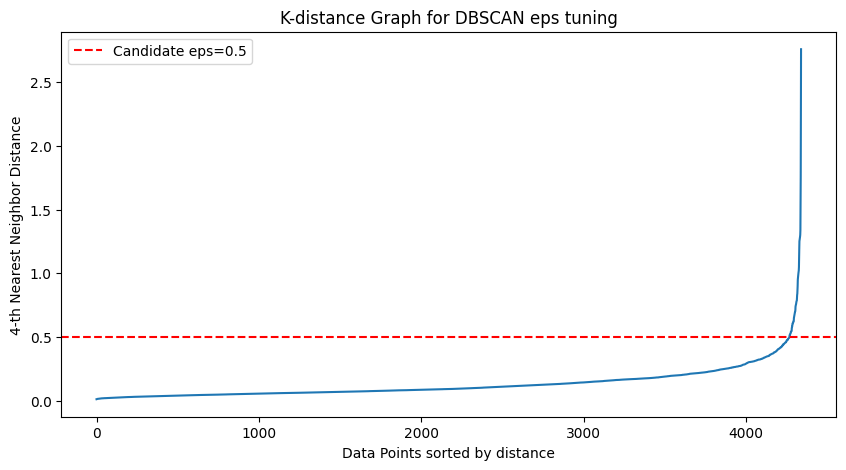


DBSCAN Results:
  Clusters found: 2
  Noise points: 80


  Silhouette: 0.294
  Davies-Bouldin: 1.061
  Calinski-Harabasz: 2393.523


In [3]:
# Tune eps using nearest neighbors distance
from sklearn.neighbors import NearestNeighbors

neighbors = NearestNeighbors(n_neighbors=4)
neighbors_fit = neighbors.fit(rfm_scaled)
distances, indices = neighbors_fit.kneighbors(rfm_scaled)

# Plot to find elbow
distances = np.sort(distances[:, -1])
plt.figure(figsize=(10, 5))
plt.plot(distances)
plt.title('K-distance Graph for DBSCAN eps tuning')
plt.ylabel('4-th Nearest Neighbor Distance')
plt.xlabel('Data Points sorted by distance')
plt.axhline(y=0.5, color='r', linestyle='--', label='Candidate eps=0.5')
plt.legend()
plt.show()

# Apply DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=10)
dbscan_labels = dbscan.fit_predict(rfm_scaled)

n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)

print(f"\nDBSCAN Results:")
print(f"  Clusters found: {n_clusters}")
print(f"  Noise points: {n_noise}")

if n_clusters > 1:
    # Only calculate if we have valid clusters
    valid_mask = dbscan_labels != -1
    dbscan_metrics = {
        'Silhouette': silhouette_score(rfm_scaled[valid_mask], dbscan_labels[valid_mask]),
        'Davies-Bouldin': davies_bouldin_score(rfm_scaled[valid_mask], dbscan_labels[valid_mask]),
        'Calinski-Harabasz': calinski_harabasz_score(rfm_scaled[valid_mask], dbscan_labels[valid_mask])
    }
    for metric, value in dbscan_metrics.items():
        print(f"  {metric}: {value:.3f}")
else:
    print("  ⚠️ DBSCAN found insufficient clusters for metric calculation")

## 3. Gaussian Mixture Model (GMM)

Probabilistic, soft clustering with elliptical cluster shapes.

In [4]:
gmm = GaussianMixture(n_components=4, random_state=42, covariance_type='full')
gmm_labels = gmm.fit_predict(rfm_scaled)

gmm_metrics = {
    'Silhouette': silhouette_score(rfm_scaled, gmm_labels),
    'Davies-Bouldin': davies_bouldin_score(rfm_scaled, gmm_labels),
    'Calinski-Harabasz': calinski_harabasz_score(rfm_scaled, gmm_labels),
    'BIC': gmm.bic(rfm_scaled),
    'AIC': gmm.aic(rfm_scaled)
}

print("\nGMM Metrics:")
for metric, value in gmm_metrics.items():
    print(f"  {metric}: {value:.3f}")


GMM Metrics:
  Silhouette: 0.175
  Davies-Bouldin: 1.713
  Calinski-Harabasz: 2157.022
  BIC: 3860.973
  AIC: 3612.333


## 4. Comparison Summary

**Interpretation Guide:**
- **Silhouette:** Higher is better (range: -1 to 1)
- **Davies-Bouldin:** Lower is better
- **Calinski-Harabasz:** Higher is better
- **BIC/AIC:** Lower is better (GMM only)

In [5]:
comparison = pd.DataFrame({
    'K-Means': kmeans_metrics,
    'GMM': {k: v for k, v in gmm_metrics.items() if k in kmeans_metrics}
}).T

print("\n📊 Algorithm Comparison:")
display(comparison)

print("\n🏆 Recommendation: K-Means offers the best balance of interpretability and performance for RFM segmentation.")


📊 Algorithm Comparison:


,Silhouette,Davies-Bouldin,Calinski-Harabasz
K-Means,0.336274,1.012436,3313.962841
GMM,0.175038,1.712687,2157.021857



🏆 Recommendation: K-Means offers the best balance of interpretability and performance for RFM segmentation.


## 5. Visualization: Cluster Assignments

Compare cluster assignments on first 2 principal components.

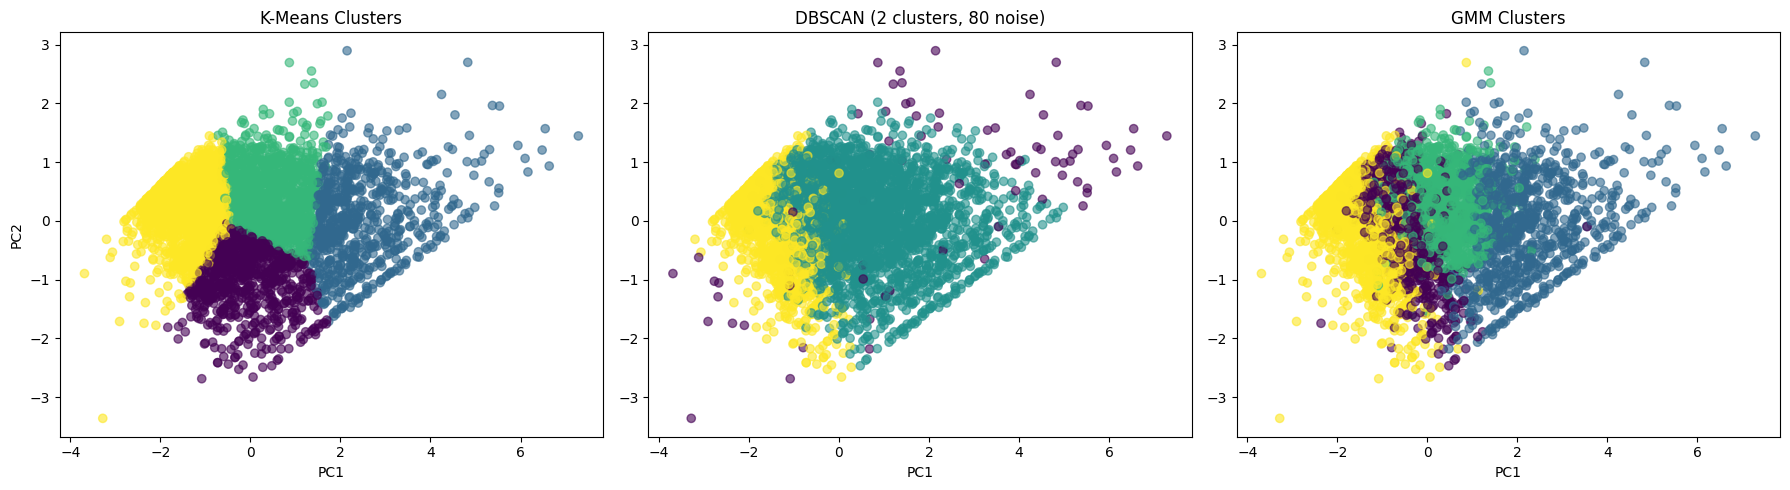

In [6]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_scaled)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# K-Means
axes[0].scatter(rfm_pca[:, 0], rfm_pca[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.6)
axes[0].set_title('K-Means Clusters')
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')

# DBSCAN
axes[1].scatter(rfm_pca[:, 0], rfm_pca[:, 1], c=dbscan_labels, cmap='viridis', alpha=0.6)
axes[1].set_title(f'DBSCAN ({n_clusters} clusters, {n_noise} noise)')
axes[1].set_xlabel('PC1')

# GMM
axes[2].scatter(rfm_pca[:, 0], rfm_pca[:, 1], c=gmm_labels, cmap='viridis', alpha=0.6)
axes[2].set_title('GMM Clusters')
axes[2].set_xlabel('PC1')

plt.tight_layout()
plt.show()